In [31]:
%matplotlib inline

In [32]:
import pandas as pd
import os
import glob
import smopy
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from scipy import ndimage
from datetime import datetime
import imageio

In [33]:
%time df = pd.read_csv('segment_master.csv', parse_dates=['date'])

Wall time: 26.8 s


In [34]:
df.head()

segment_ID trans_mode   latitude   longitude       date  \
0  Data\010_20080328145254_train      train  39.894178  116.318200 2008-03-28   
1  Data\010_20080328145254_train      train  39.894505  116.321132 2008-03-28   
2  Data\010_20080328145254_train      train  39.894953  116.326452 2008-03-28   
3  Data\010_20080328145254_train      train  39.894600  116.332542 2008-03-28   
4  Data\010_20080328145254_train      train  39.889622  116.337040 2008-03-28   

       time    time_stamp  time_delta  distance_delta   velocity  \
0  14:54:40  1.206716e+09         0.0        0.000000   0.000000   
1  14:55:14  1.206716e+09        34.0      253.375122   7.452209   
2  14:56:13  1.206716e+09        59.0      457.703184   7.757681   
3  14:57:12  1.206716e+09        59.0      522.318587   8.852857   
4  14:58:11  1.206716e+09        59.0      673.422397  11.413939   

   velocity_ratio  acceleration  acceleration_ratio  bearing_delta  \
0        0.000000      0.000000            0.000000       0.000000   
1        0.000000      0.219183            0.000000      81.728206   
2        0.040991      0.005177            0.976378      83.734582   
3        0.141173      0.018562            2.585198      94.318545   
4        0.289294      0.043408            1.338511     145.266086   

   bearing_delta_redirect  
0                0.000000  
1                0.000000  
2                2.006376  
3               10.583963  
4               50.947541

In [35]:
df.describe()

latitude     longitude    time_stamp    time_delta  distance_delta  \
count  5.249713e+06  5.249713e+06  5.249713e+06  5.249713e+06    5.249713e+06   
mean   3.946711e+01  1.144523e+02  1.240006e+09  3.617323e+00    2.300882e+01   
std    2.386457e+00  1.541771e+01  3.643679e+07  6.356356e+01    1.653214e+03   
min    1.824990e+01 -1.799696e+02  1.176373e+09 -1.261400e+04    0.000000e+00   
25%    3.992383e+01  1.163086e+02  1.216959e+09  1.000000e+00    1.510395e+00   
50%    3.997515e+01  1.163314e+02  1.224117e+09  2.000000e+00    4.897413e+00   
75%    3.999159e+01  1.164181e+02  1.245997e+09  2.000000e+00    1.644988e+01   
max    4.001667e+02  1.799969e+02  1.325345e+09  2.145300e+04    2.113190e+06   

           velocity  velocity_ratio  acceleration  acceleration_ratio  \
count  5.249713e+06    5.249713e+06  5.249713e+06        5.249713e+06   
mean   6.839888e+00    7.307080e-01  1.765379e-03        2.050571e+10   
std    1.159858e+01    2.061018e+01  2.225208e+00        2.665726e+13   
min   -6.995471e+00   -4.174182e+01 -1.029460e+03        0.000000e+00   
25%    8.774204e-01    3.326558e-02 -2.271579e-01        7.985542e-01   
50%    2.484080e+00    1.671173e-01  0.000000e+00        1.455654e+00   
75%    9.012012e+00    5.108181e-01  2.273663e-01        2.797927e+00   
max    2.611715e+03    2.432312e+04  6.529289e+02        4.198625e+16   

       bearing_delta  bearing_delta_redirect  
count   5.249713e+06            5.249713e+06  
mean    1.778074e+02            4.235280e+01  
std     1.096367e+02            8.323794e+01  
min     0.000000e+00            0.000000e+00  
25%     8.837978e+01            1.278290e+00  
50%     1.781320e+02            6.806953e+00  
75%     2.700000e+02            2.962648e+01  
max     3.599828e+02            3.599640e+02

In [36]:
smopy.TILE_SERVER = 'http://tile.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png'
smopy.TILE_SIZE = 256

In [37]:
# 获取GPS数据边界点
latMin = min(df.latitude)
latMax = max(df.latitude)
longMin = min(df.longitude)
longMax = max(df.longitude)

Lowered zoom level to keep map size reasonable. (z = 2)


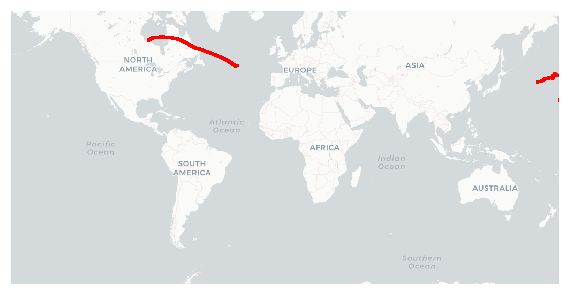

In [38]:
# 地区显示范围
mapAll = smopy.Map((latMin, longMin, latMax, longMax), z=10)
# 将经纬度映射到图上的坐标点
x, y = mapAll.to_pixels(df.latitude, df.longitude)
ax = mapAll.show_mpl(figsize=(8, 6))
ax.plot(x, y, 'or', ms=2)

In [39]:
# 北京地区的边界
latMinB = 39.64
latMaxB = 40.51
longMinB = 115.76
longMaxB = 116.88

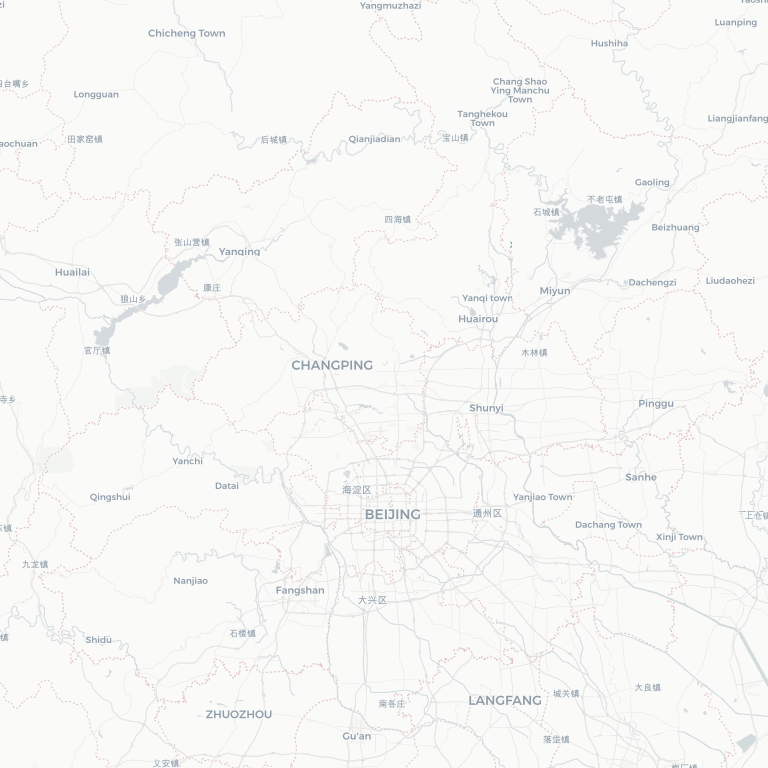

In [40]:
mapBeijing = smopy.Map((latMinB, longMinB, latMaxB, longMaxB), z=9)
mapBeijing.show_ipython()

In [41]:
# 建立北京出行信息的热力图
df['xPixel'] = mapBeijing.to_pixels(df.latitude, df.longitude)[0]
df['yPixel'] = mapBeijing.to_pixels(df.latitude, df.longitude)[1]

In [42]:
dfBeijing = df[(df.latitude.between(latMinB, latMaxB) & df.longitude.between(longMinB, longMaxB))]

In [43]:
# 设置热力图的颜色
cmap = LinearSegmentedColormap.from_list('mycmap',[(0, (1,0,0,0)), (0.5, (1,0.5,0,0.8)), (0.75, (1,1,0,0.8)), (0.875, (1,1,1,1)), (1, (1,1,1,1))])

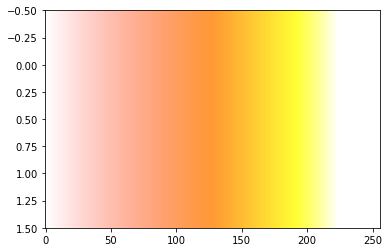

In [44]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
fig, ax = plt.subplots()
ax.imshow(gradient, aspect='auto', cmap=cmap)

D:\Software\ANACONDA\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log
  if sys.path[0] == '':


9.7852544946931488

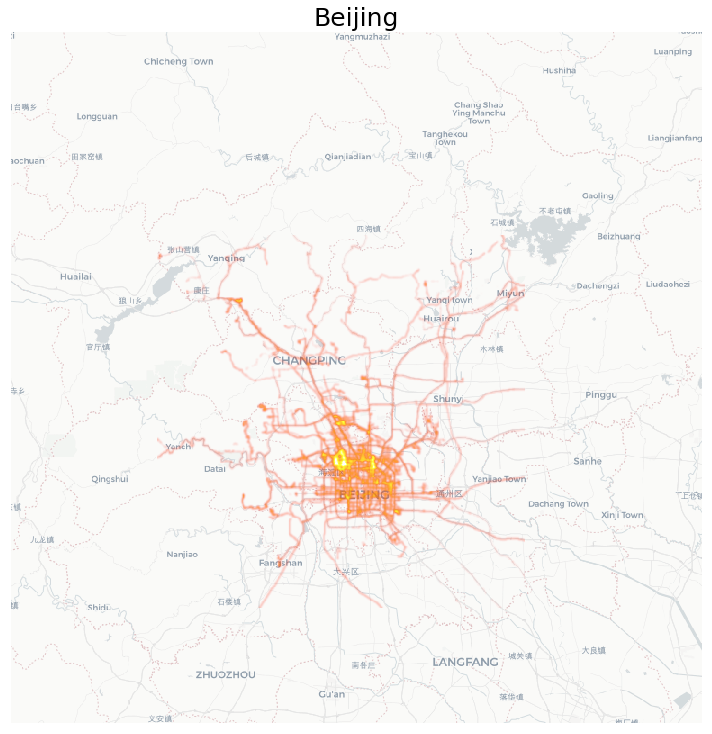

In [45]:
ax = mapBeijing.show_mpl(figsize=(12, 10))
bins=400
smoothing =1.

title = 'Beijing'

# 热力图的坐标点和边界
x = list(dfBeijing['xPixel'])
y = list(dfBeijing['yPixel'])
heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
logheatmap = np.log(heatmap)
logheatmap[np.isneginf(logheatmap)] = 0
logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')

ax.set_title(title, size=25)

# 保存图片
plt.savefig(title+'.png', bbox_inches='tight')
    
ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=10)

plt.savefig(title+'.png', bbox_inches='tight')

np.amax(logheatmap)

In [46]:
# 北京市中心
latMin = 39.8
latMax = 40
longMin = 116.2
longMax = 116.4

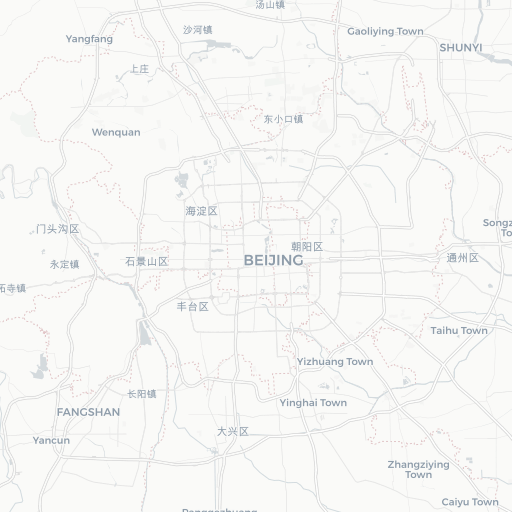

In [47]:
mapZoom = smopy.Map((latMin, longMin, latMax, longMax ), z=10)
mapZoom.show_ipython()

In [48]:
def heatMap(long, lat, area, bins=200, smoothing=1, vmax=4, title=None):
    x = area.to_pixels(lat, long)[0]
    y = area.to_pixels(lat, long)[1]
    
    ax = area.show_mpl(figsize=(12, 10))
    
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]
    
    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    
    output = ax.imshow(logheatmap, cmap=cmap, extent=extent, vmin=0, vmax=vmax)
    
    if title:
        ax.set_title(title, size=25)
        plt.savefig(title+'.png', bbox_inches='tight')
    
    print(np.amax(logheatmap))
    return output

D:\Software\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


9.32060116785


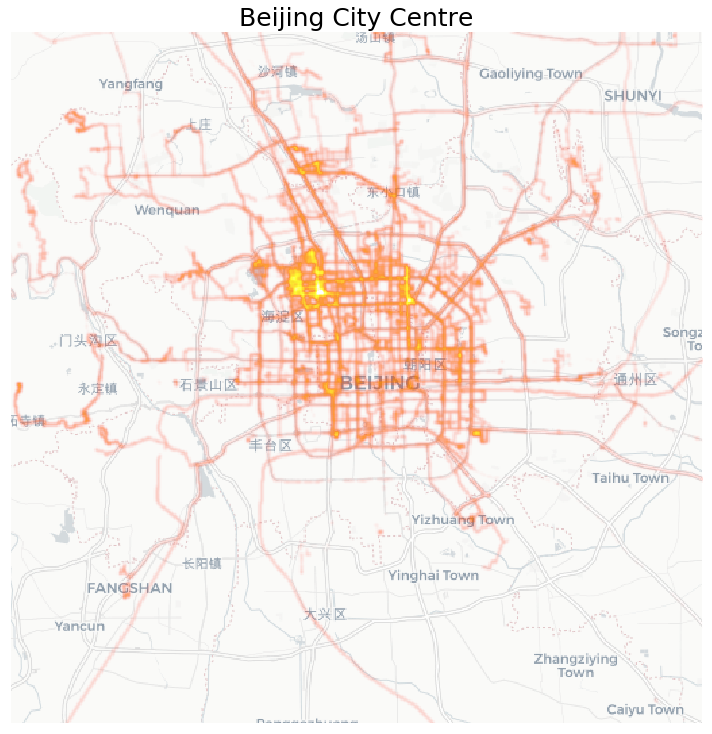

In [49]:
heatMap(dfBeijing.longitude, dfBeijing.latitude, mapZoom, bins=800, vmax=10, title='Beijing City Centre')

In [50]:
df.head()

segment_ID trans_mode   latitude   longitude       date  \
0  Data\010_20080328145254_train      train  39.894178  116.318200 2008-03-28   
1  Data\010_20080328145254_train      train  39.894505  116.321132 2008-03-28   
2  Data\010_20080328145254_train      train  39.894953  116.326452 2008-03-28   
3  Data\010_20080328145254_train      train  39.894600  116.332542 2008-03-28   
4  Data\010_20080328145254_train      train  39.889622  116.337040 2008-03-28   

       time    time_stamp  time_delta  distance_delta   velocity  \
0  14:54:40  1.206716e+09         0.0        0.000000   0.000000   
1  14:55:14  1.206716e+09        34.0      253.375122   7.452209   
2  14:56:13  1.206716e+09        59.0      457.703184   7.757681   
3  14:57:12  1.206716e+09        59.0      522.318587   8.852857   
4  14:58:11  1.206716e+09        59.0      673.422397  11.413939   

   velocity_ratio  acceleration  acceleration_ratio  bearing_delta  \
0        0.000000      0.000000            0.000000       0.000000   
1        0.000000      0.219183            0.000000      81.728206   
2        0.040991      0.005177            0.976378      83.734582   
3        0.141173      0.018562            2.585198      94.318545   
4        0.289294      0.043408            1.338511     145.266086   

   bearing_delta_redirect      xPixel      yPixel  
0                0.000000  366.164196  519.383993  
1                0.000000  367.231704  519.228815  
2                2.006376  369.168657  519.016215  
3               10.583963  371.385958  519.183732  
4               50.947541  373.023630  521.545969

In [51]:
len(df.segment_ID.unique())

9321

In [52]:
# 以datetime为横轴
df.set_index('datetime', inplace=True)

Wall time: 3.5 s


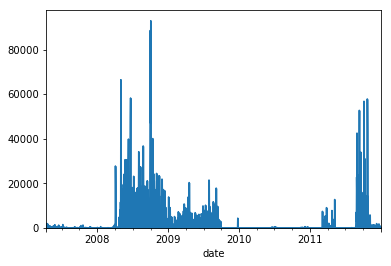

In [53]:
%time df.resample('D').count().latitude.plot(kind='area')

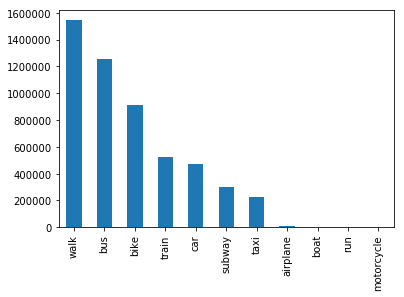

In [54]:
df['trans_mode'].value_counts().plot(kind='bar')

In [55]:
dfRoads = dfBeijing[dfBeijing['trans_mode'].isin(['car', 'bus', 'taxi'])]

D:\Software\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


7.52635231461


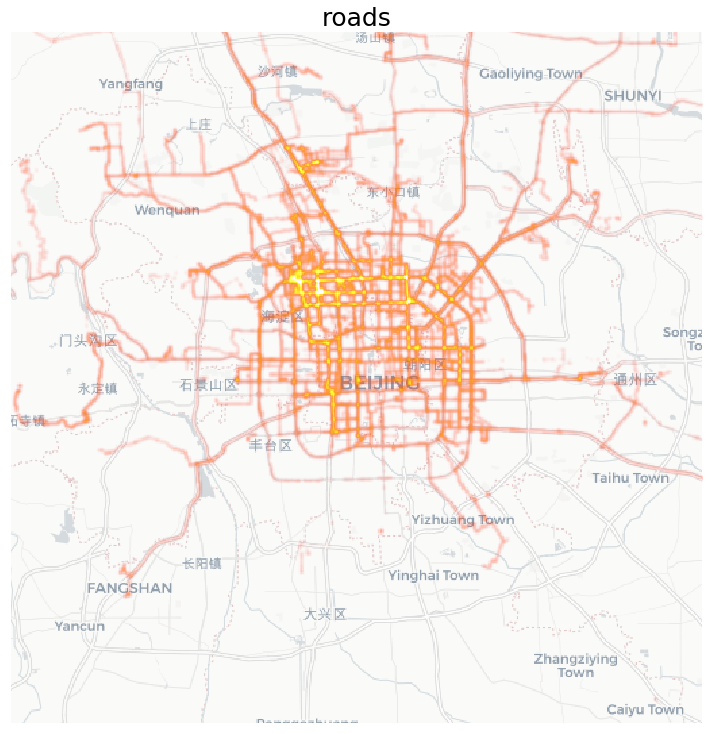

In [56]:
heatMap(dfRoads.longitude, dfRoads.latitude, mapZoom, bins=800, vmax=7, title='roads')

D:\Software\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


8.64009609005


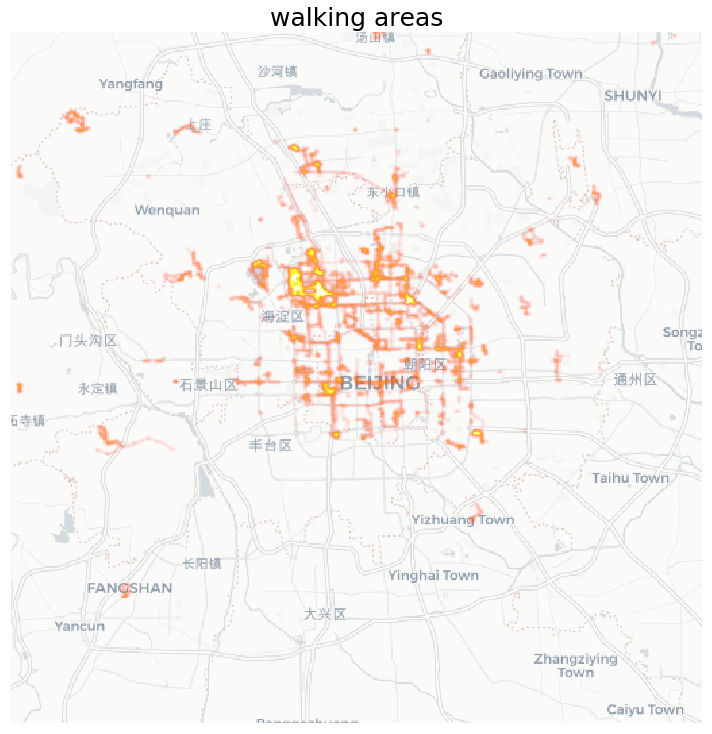

In [57]:
dfWalking = dfBeijing[dfBeijing['trans_mode'] == 'walk']
heatMap(dfWalking.longitude, dfWalking.latitude, mapZoom, bins=800, vmax=8, title='walking areas')

In [58]:
df.head()

segment_ID trans_mode   latitude   longitude  \
date                                                                          
2008-03-28  Data\010_20080328145254_train      train  39.894178  116.318200   
2008-03-28  Data\010_20080328145254_train      train  39.894505  116.321132   
2008-03-28  Data\010_20080328145254_train      train  39.894953  116.326452   
2008-03-28  Data\010_20080328145254_train      train  39.894600  116.332542   
2008-03-28  Data\010_20080328145254_train      train  39.889622  116.337040   

                time    time_stamp  time_delta  distance_delta   velocity  \
date                                                                        
2008-03-28  14:54:40  1.206716e+09         0.0        0.000000   0.000000   
2008-03-28  14:55:14  1.206716e+09        34.0      253.375122   7.452209   
2008-03-28  14:56:13  1.206716e+09        59.0      457.703184   7.757681   
2008-03-28  14:57:12  1.206716e+09        59.0      522.318587   8.852857   
2008-03-28  14:58:11  1.206716e+09        59.0      673.422397  11.413939   

            velocity_ratio  acceleration  acceleration_ratio  bearing_delta  \
date                                                                          
2008-03-28        0.000000      0.000000            0.000000       0.000000   
2008-03-28        0.000000      0.219183            0.000000      81.728206   
2008-03-28        0.040991      0.005177            0.976378      83.734582   
2008-03-28        0.141173      0.018562            2.585198      94.318545   
2008-03-28        0.289294      0.043408            1.338511     145.266086   

            bearing_delta_redirect      xPixel      yPixel  
date                                                        
2008-03-28                0.000000  366.164196  519.383993  
2008-03-28                0.000000  367.231704  519.228815  
2008-03-28                2.006376  369.168657  519.016215  
2008-03-28               10.583963  371.385958  519.183732  
2008-03-28               50.947541  373.023630  521.545969

In [59]:
def getTime(x):
    return datetime.strptime(str(x), '%H').strftime('%Hh%M')

In [61]:
dfBeijing.time[1]

'14:55:14'

In [62]:
t = dfBeijing.time[1]
t[0:2]

'14'

In [63]:
dfBeijing.time[1][0:2]

'14'

D:\Software\ANACONDA\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log
  # Remove the CWD from sys.path while we load stuff.


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
6.28712130116
6.53401639675
6.02641035503
5.66082118813
6.06674902812
5.46414589253
4.6722312636
3.17557564914
3.33191607795
2.67953942634


D:\Software\ANACONDA\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


1.97847804601
2.68003066803
3.676059742
4.56292185757


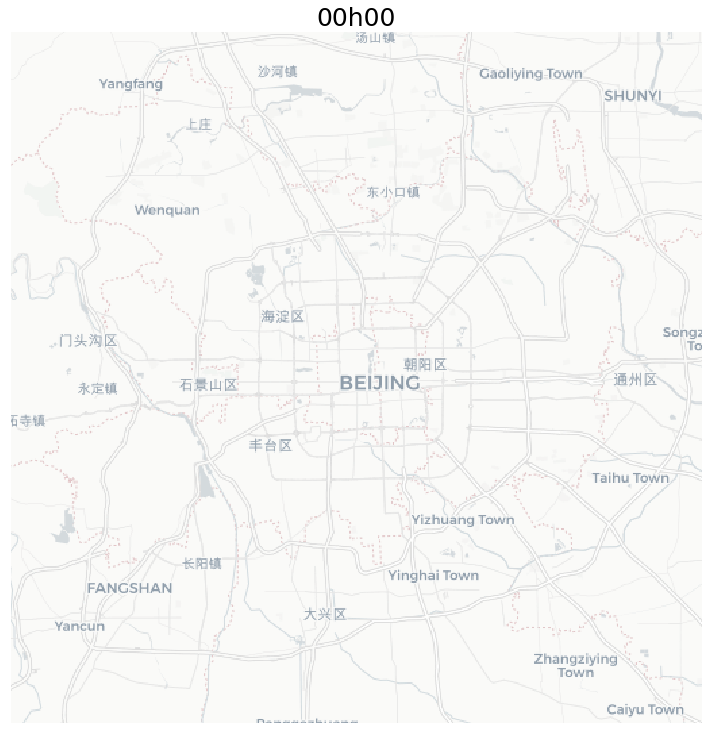

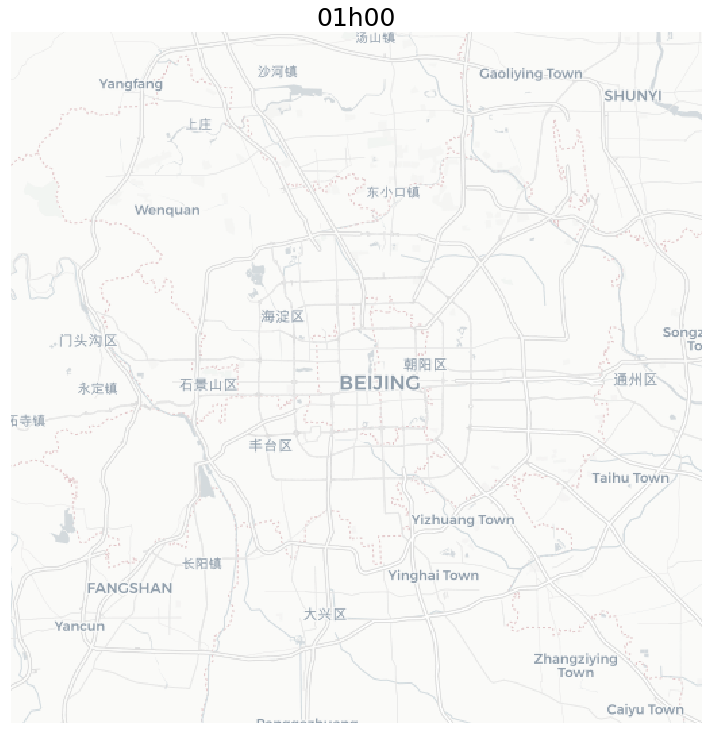

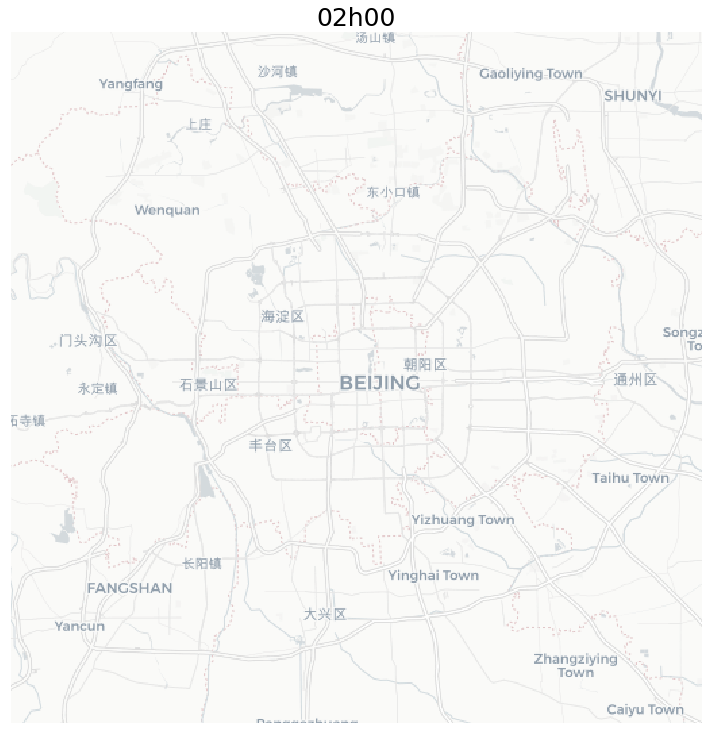

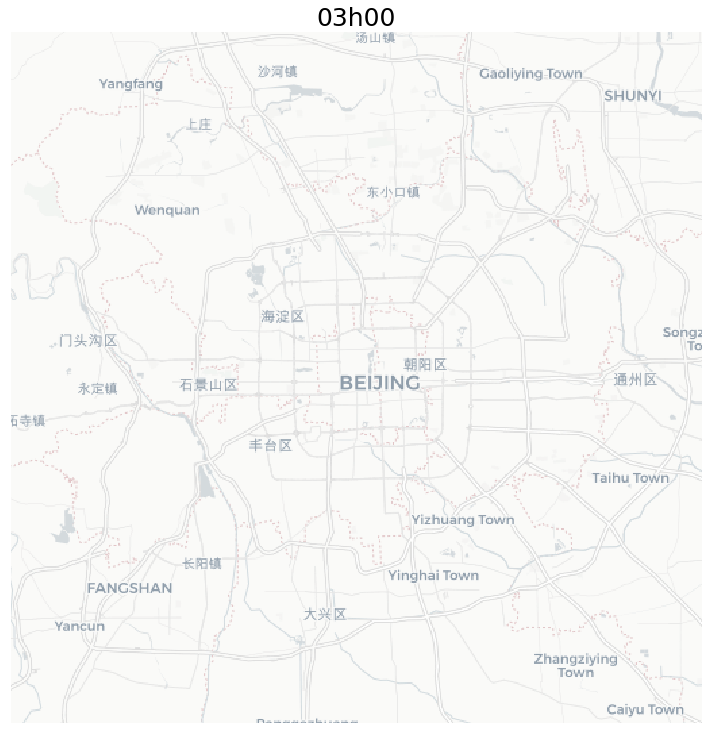

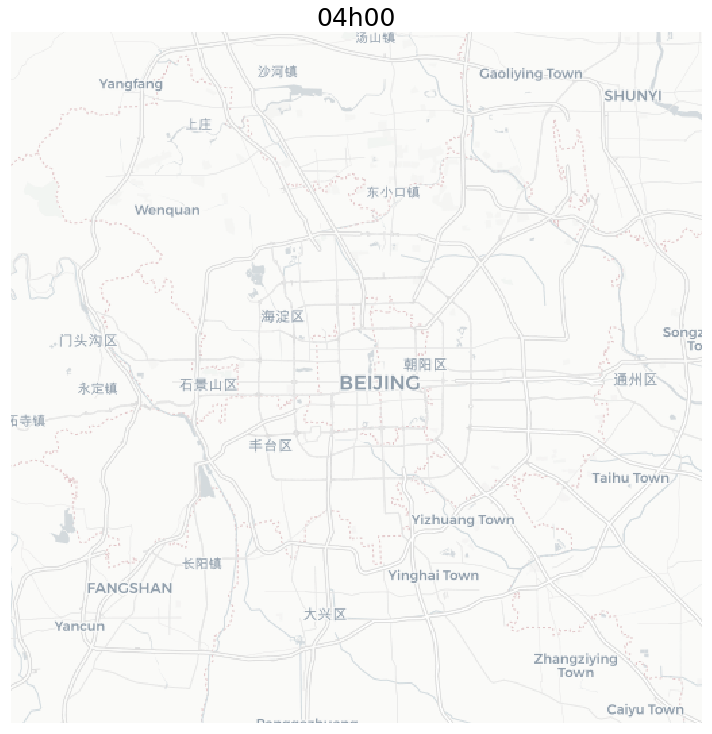

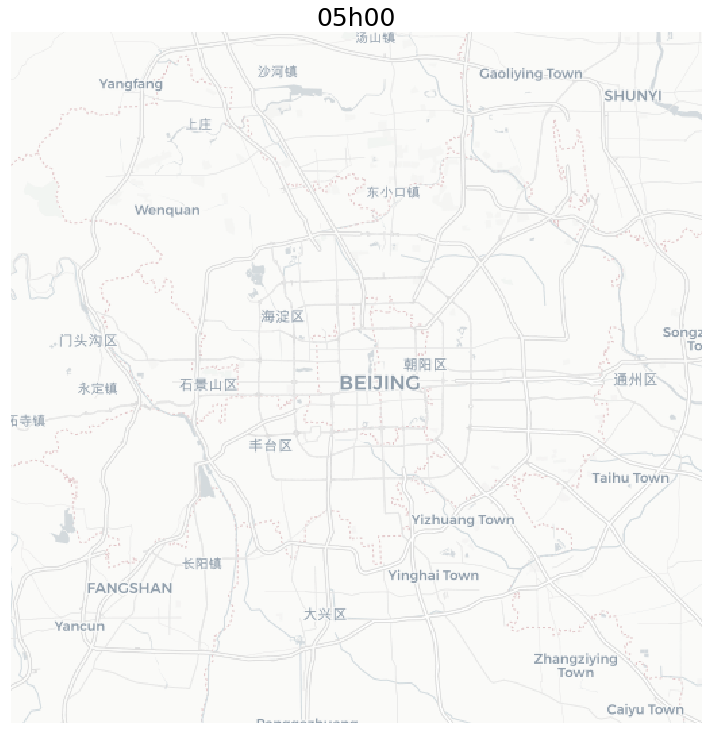

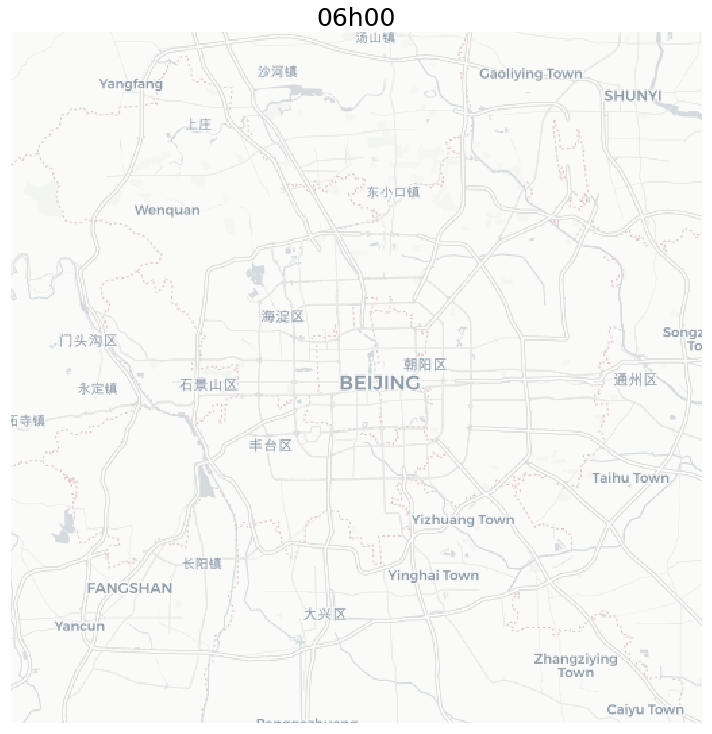

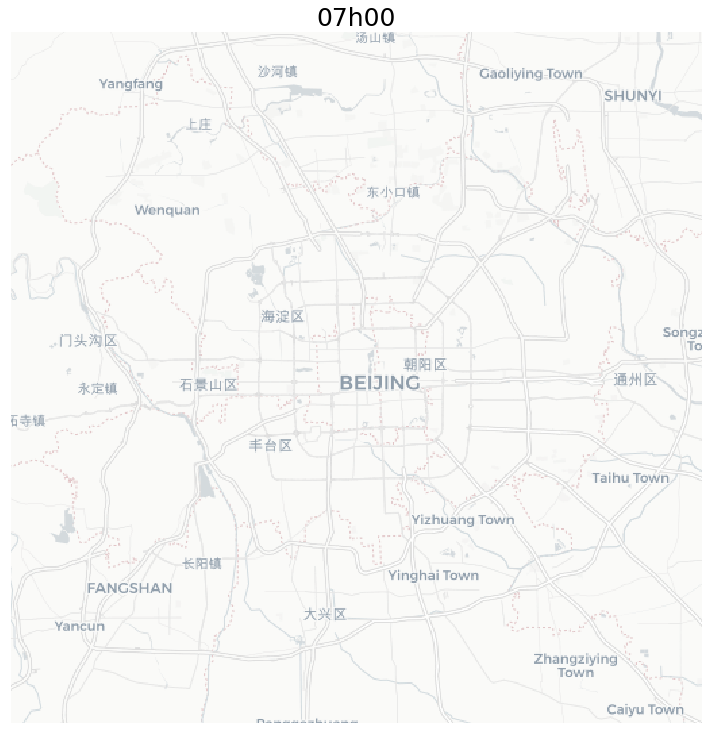

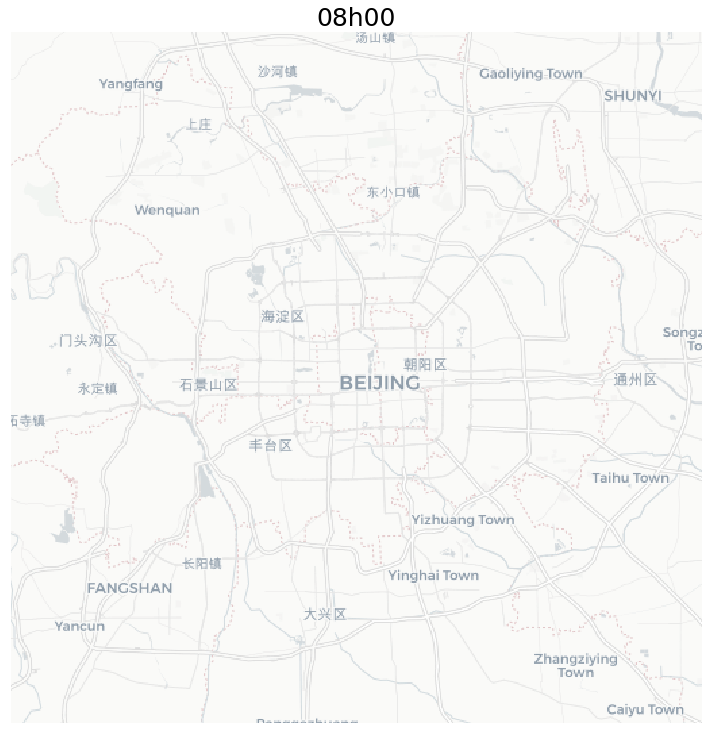

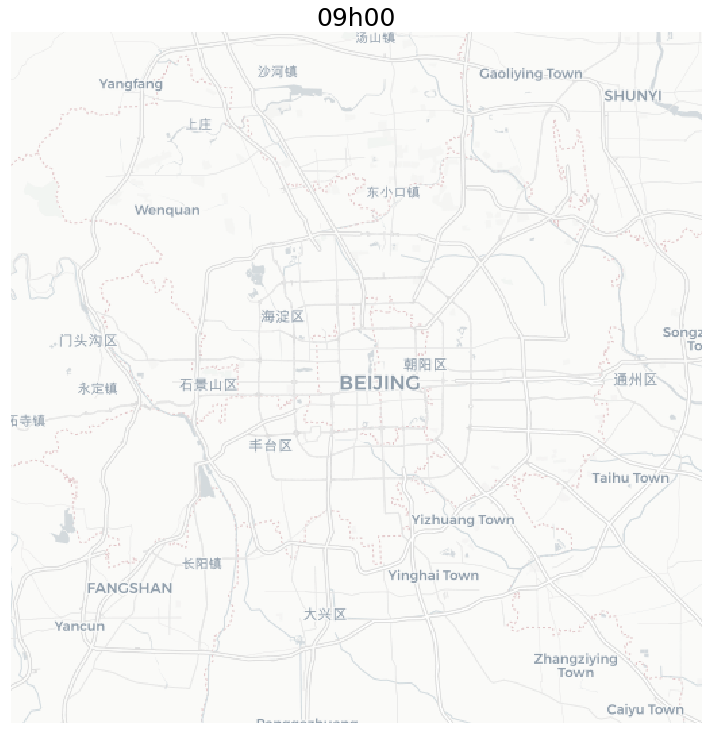

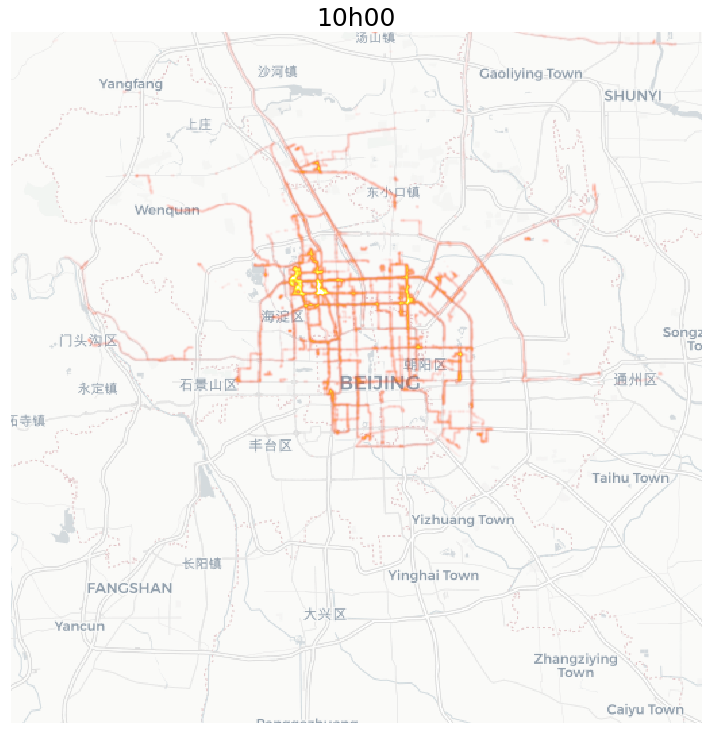

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


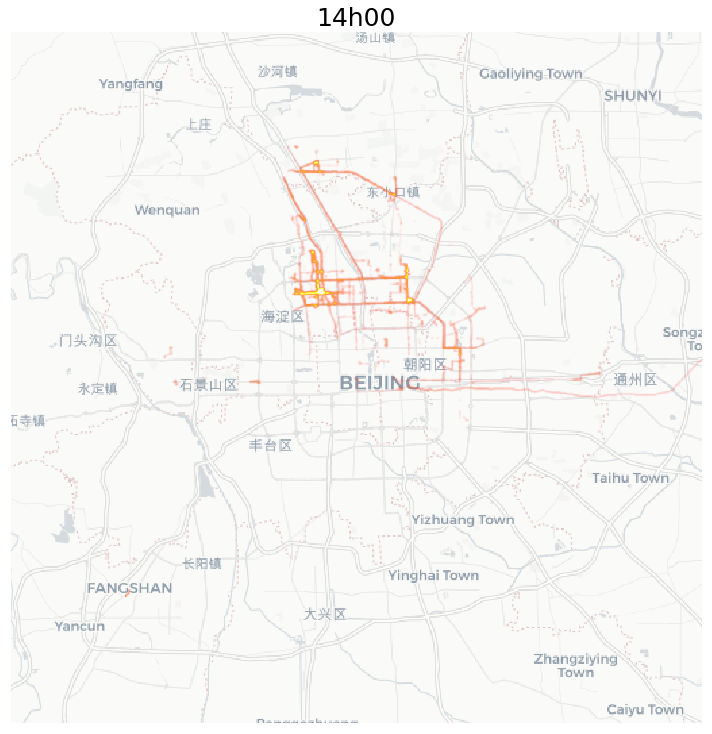

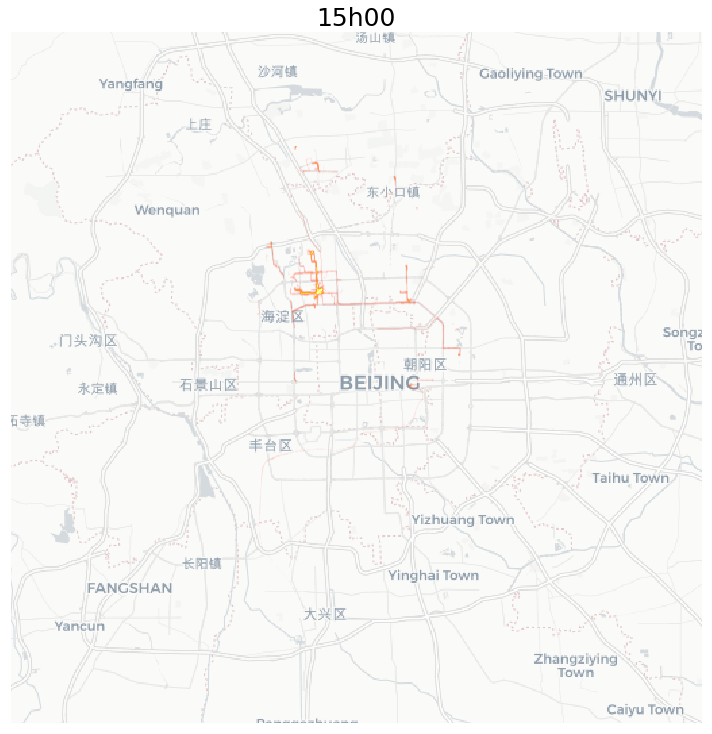

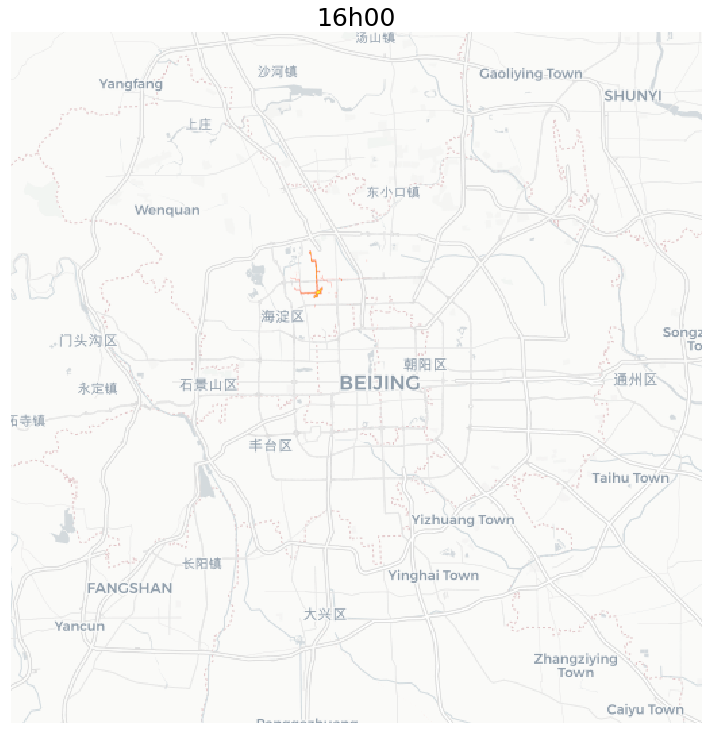

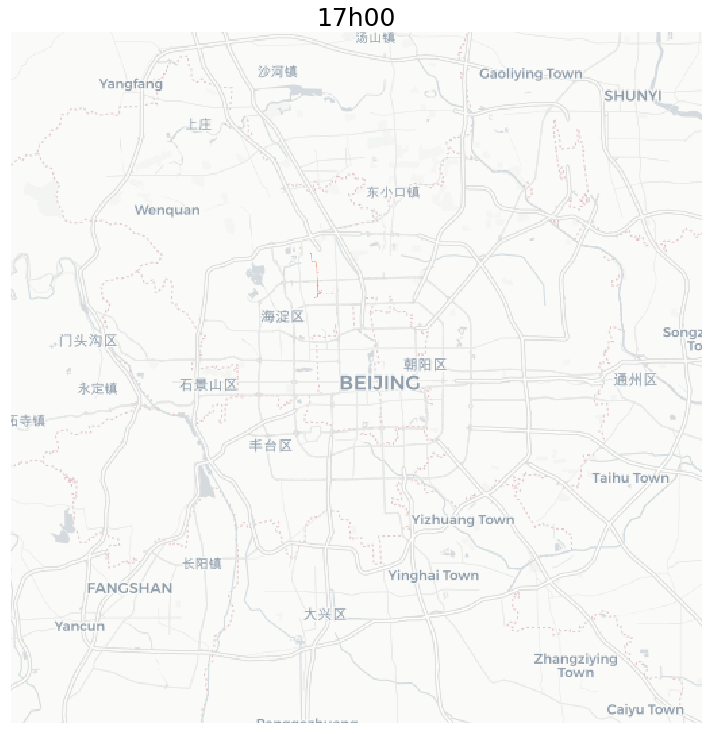

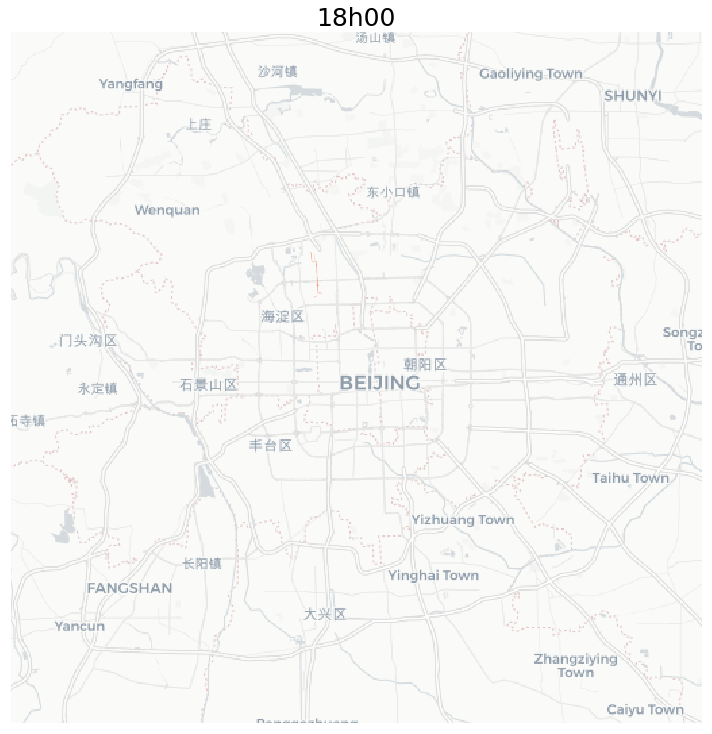

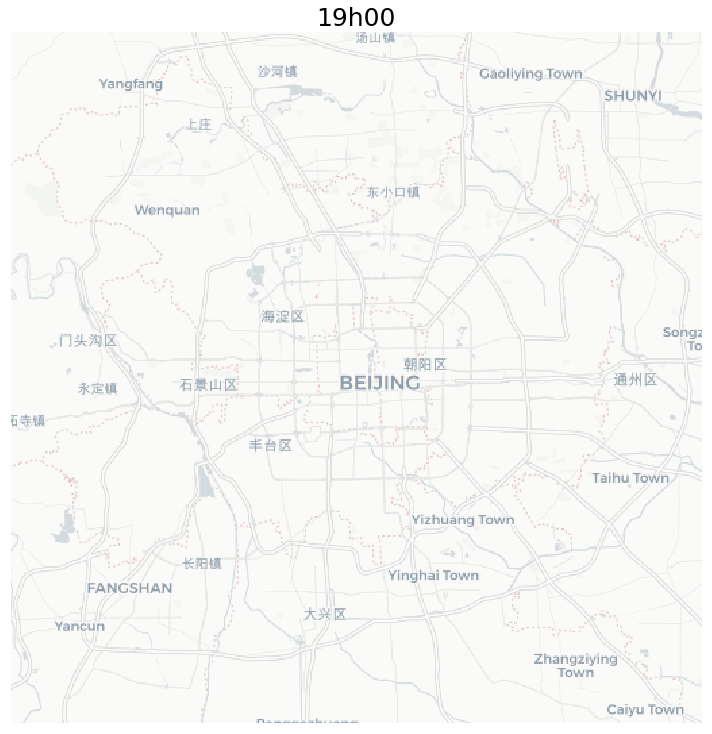

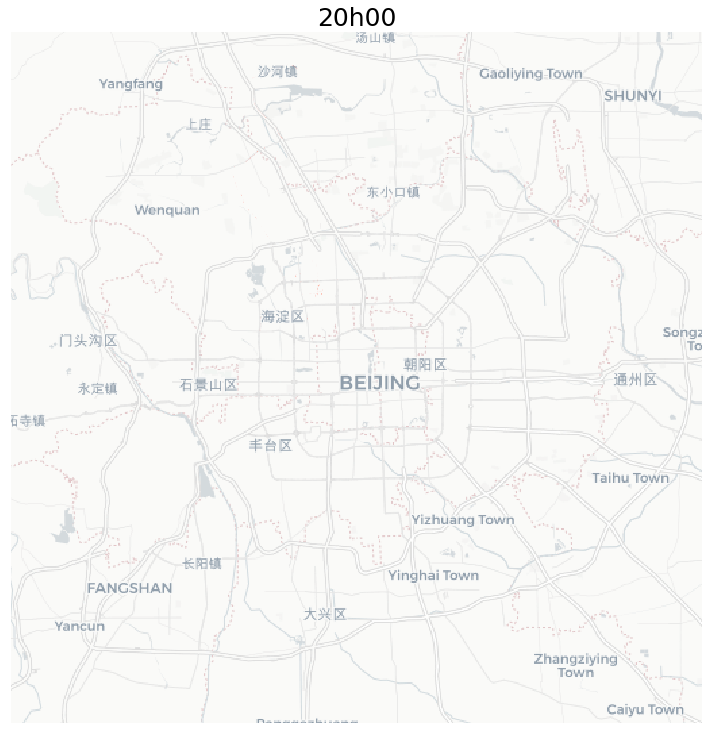

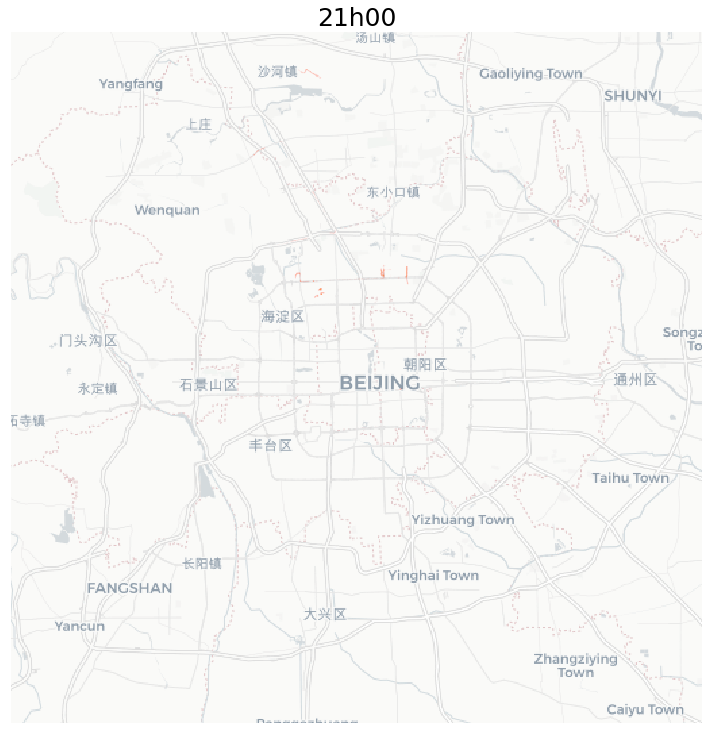

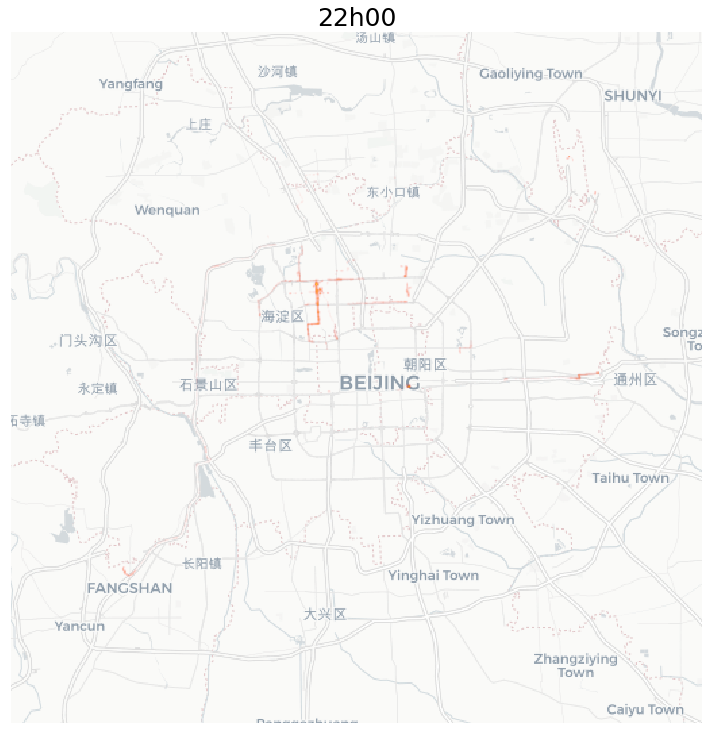

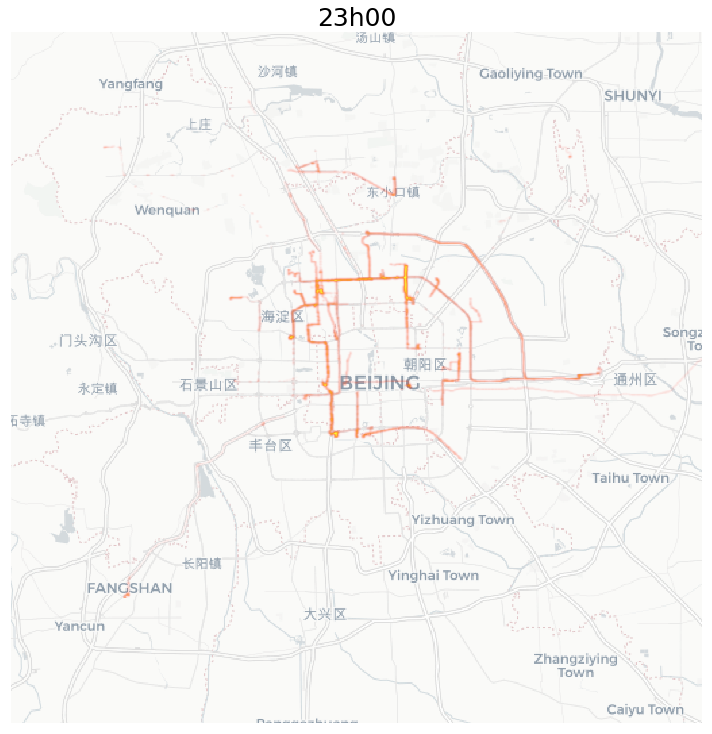

In [66]:
for i in range(24):
    dfHour = dfBeijing[dfBeijing['time'].str[0:2] == str(i)]
    heatMap(dfHour.longitude, dfHour.latitude, mapZoom, bins=800, vmax=6, title=getTime(i))

In [65]:
'14' == str(14)

True